# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [22]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import webbrowser as wb

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
print("done")

done


## Env setup

In [23]:
# This is needed to display the images.
%matplotlib inline

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

## Object detection imports
Here are the imports from the object detection module.

In [24]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [25]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

## Download Model

In [26]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory.

In [27]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [28]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


## Helper code

In [29]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [113]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(3, 4) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [78]:
def getClassLabelfromClassid(classId):
    dict_map_classId_classLabel = {'1' : 'Car','18' :'Dog', '38' : 'Kite', '1': 'Human'}
    class_Id_string= str(classId)
    classLabel=dict_map_classId_classLabel[class_Id_string]
    return classLabel
    
    
    
    

In [79]:
def createLinks(image_paths,boxes, scores, classes, num):
    boxes=np.squeeze(boxes)
    classes=np.squeeze(classes).astype(np.int32)
    scores=np.squeeze(scores)
    for index,score in enumerate(scores):
        if score>0.5:
            ##classLabel = getClassLabelfromClassid(classes[index])
            #print("In the image there is a {}".format(classLabel))
            ###  
            my_string= "https://en.wikipedia.org/wiki/"
            #print(classes[index])
            Url=my_string + category_index[classes[index]]['name']
            wb.open_new_tab(Url)

In [80]:
def correctWebUrl(classLabel):
    dict_classLabel_webpage = {'Car': 'https://en.wikipedia.org/wiki/Car', 'Dog' : 'https://en.wikipedia.org/wiki/Dog', 'Kite' : 'https://en.wikipedia.org/wiki/Kite', 'Human': 'https://en.wikipedia.org/wiki/Human'}
    return dict_classLabel_webpage[classLabel]

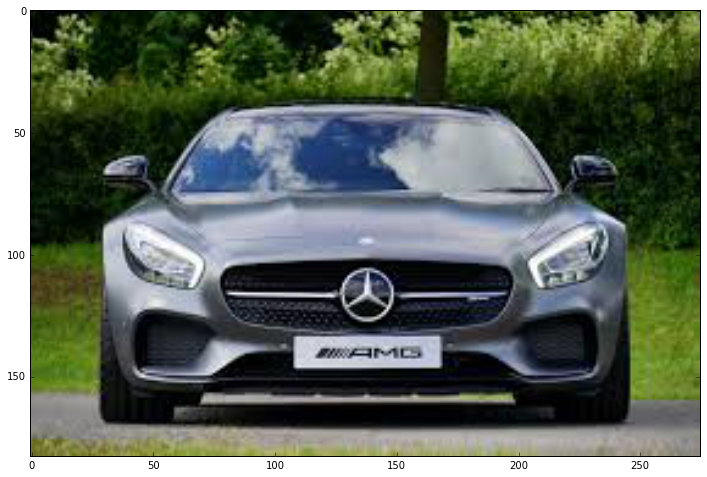

In [101]:
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    for image_path in TEST_IMAGE_PATHS:
      image = Image.open(image_path)
      #print(image_path)
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      # Actual detection.
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)

In [82]:
def getBox(boxes,scores,classes,width,height):
        boxes=np.squeeze(boxes)
        scores=np.squeeze(scores)
        classes=np.squeeze(classes).astype(np.int32)
        myList=[]
        for index,score in enumerate(scores):
            if score > 0.5:
                #print("here")
                x0=boxes[index][1]*width
                y0=boxes[index][0]*height
                x1=boxes[index][3]*width
                y1=boxes[index][2]*height
                myList.append([x0,y0,x1,y1,classes[index]])
                #print(myList)
        #print(myList)
        return(myList)
                #print(boxes[index])
                #print("The widht is {}".format(width))
                #print("The height is {}".format(height))
                #print("X0 = {} ".format(boxes[index][1]*width))
                #print("y0 = {} ".format(boxes[index][0]*height))
                #print("X1 = {} ".format(boxes[index][3]*width))
                #print("y1 = {} ".format(boxes[index][2]*height))
                
# This is the output shape ymin,xmin,ymax,xmax,

38
1
1
38
1
1
38
38


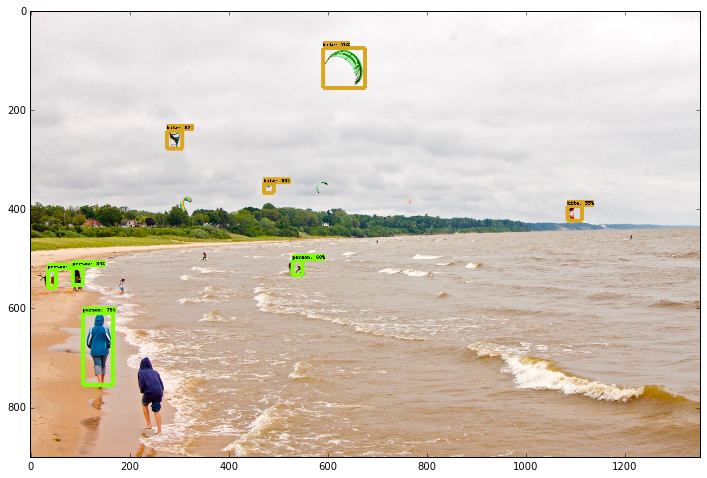

In [95]:

with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    for image_path in TEST_IMAGE_PATHS:
      #print(image_path)
      image = Image.open(image_path)
      width, height =image.size
      #print(image_path)
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      # Actual detection.
      (boxes, scores, classes, num) = sess.run(
          [detection_boxes, detection_scores, detection_classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      # Visualization of the results of a detection.
      createLinks(image_path,boxes,scores,classes,num)
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=8)
      getBox(boxes, scores,classes,width,height)
      # The function aboe print the boxes and so on! 
      # 
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)

In [128]:
def objectDetection(TEST_IMAGE_PATH):
    with detection_graph.as_default():
      with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        result_list=[]
        for image_path in TEST_IMAGE_PATH:
          #print(image_path)
          image = Image.open(image_path)
          width, height =image.size
          #print(image_path)
          # the array based representation of the image will be used later in order to prepare the
          # result image with boxes and labels on it.
          image_np = load_image_into_numpy_array(image)
          # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
          image_np_expanded = np.expand_dims(image_np, axis=0)
          # Actual detection.
          (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})
          # Visualization of the results of a detection.
          #createLinks(image_path,boxes,scores,classes,num)
          vis_util.visualize_boxes_and_labels_on_image_array(
              image_np,
              np.squeeze(boxes),
              np.squeeze(classes).astype(np.int32),
              np.squeeze(scores),
              category_index,
              use_normalized_coordinates=True,
              line_thickness=8)
          #getBox(boxes, scores,classes,width,height)
          # The function aboe print the boxes and so on! 
          # 
          #plt.figure(figsize=IMAGE_SIZE)
          #plt.imshow(image_np)
          result_list.append(getBox(boxes, scores,classes,width,height))
        return result_list

In [147]:
results=objectDetection(TEST_IMAGE_PATH)
#print(results)

In [148]:
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATH = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 2) ]

In [149]:
from collections import namedtuple
import tkinter as tk

Rect = namedtuple('Rect', 'x0, y0, x1, y1')

class ImageMapper(object):
    def __init__(self, image, img_rects):
        self.width, self.height = image.width(), image.height()
        #print(self.width, self.height)
        self.img_rects = img_rects
        
    def find_rect(self, x, y):
        #print(x,y)
        for i, r in enumerate(self.img_rects):
            if (r.x0 <= x <= r.x1) and (r.y0 <= y <= r.y1):
                return i
        return None

class Demo(tk.Frame):
    image_reacts=[]
    Rect = namedtuple('Rect', 'x0, y0, x1, y1')
    labels=[]
    def __init__(self, reacts,labels,master=None,):
        tk.Frame.__init__(self, master)
        self.grid()
        self.create_widgets()
        self.setReact(reacts)
        self.setLabels(labels)
    
    def setReact(self,image_rects):
        for image_react in image_rects:
            self.image_reacts.append(image_react)
        
    def create_widgets(self):
        self.msg_text = tk.StringVar()
        self.msg = tk.Message(self, textvariable=self.msg_text, width=100)
        self.msg.grid(row=0, column=0)

        #self.picture = tk.PhotoImage(file='image1.gif')
                        # 'x0, y0, x1, y1'
        #img_rects = [Rect(24, 24, 326, 548),
                     #Rect(401, 63, 996, 609)]
        #self.imagemapper = ImageMapper(self.picture, img_rects)
        path = TEST_IMAGE_PATH[0]

        #Creates a Tkinter-compatible photo image, which can be used everywhere Tkinter expects an image object.
        self.picture = ImageTk.PhotoImage(Image.open(path))

        self.imagemapper = ImageMapper(self.picture, self.image_reacts)
        # use Label widget to display image
        self.image = tk.Label(self, image=self.picture, borderwidth=0)
        self.image.bind('<Button-1>', self.image_click)
        self.image.grid(row=1, column=0)

        self.quitButton = tk.Button(self, text='Quit', command=self.quit)
        self.quitButton.grid(row=2, column=0)

    def image_click(self, event):
        hit = self.imagemapper.find_rect(event.x, event.y)
        self.msg_text.set('{} clicked'.format('nothing' if hit is None else
                                              'rect[{}]'.format(hit)))
        #print("the label of the hit is {}".format(self.labels[hit]))
        num=self.labels[hit] 
        self.openLink(num)
    
    def setLabels(self,labels):
        self.labels=labels
           
    def openLink(self, num):
        my_string= "https://en.wikipedia.org/wiki/"
        Url=my_string + category_index[int(num)]['name']
        wb.open_new_tab(Url)

        
results = objectDetection(TEST_IMAGE_PATH)
results = np.squeeze(results)
Reacts=[]
Labels=[]
try:
    results.shape[1]
    for result in results:
        Reacts.append(Rect(result[0], result[1],result[2], result[3]))
        Labels.append(result[4])
except (ValueError,IndexError):
    Reacts.append(Rect(results[0], results[1],results[2], results[3]))
    Labels.append(results[4])
app = Demo(Reacts,Labels)
app.master.title('Image Mapper')
app.mainloop()

Exception in Tkinter callback
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/tkinter/__init__.py", line 1549, in __call__
    return self.func(*args)
  File "<ipython-input-149-e973dc26ec4c>", line 63, in image_click
    num=self.labels[hit]
TypeError: list indices must be integers or slices, not NoneType
Exception in Tkinter callback
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/tkinter/__init__.py", line 1549, in __call__
    return self.func(*args)
  File "<ipython-input-149-e973dc26ec4c>", line 63, in image_click
    num=self.labels[hit]
TypeError: list indices must be integers or slices, not NoneType
Exception in Tkinter callback
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/tkinter/__init__.py", line 1549, in __call__
    return self.func(*args)
  File "<ipython-input-149-e973dc26ec4c>", line 63, in i

In [98]:
#To do! Make sure it can handle another image!
#Set up so the correct label is return as string and not ID 
# Great work Niklas!!

done
